# Flatiron School Phase 1 Project

This Jupyter Notebook contains analyses of various movie-related datasets. The point the of these analyses is to produce three recommendations for fictional stakeholders at Microsoft, who are looking to get into the movie business.

After conducting initial EDA on these datasets, I have produced my three recommendations. I will divide this notebook into three sections: one focusing on budget, another focusing on genre, and one focusing on the type of cast and crew.

In [914]:
# Importing the required packages

import pandas as pd
import pandasql
import numpy as np
from pandasql import sqldf
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
pysqldf = lambda q: sqldf(q, globals())

In [915]:
# Importing plan text-formatted data files
boxofficemojo = pd.read_csv("data/bom.movie_gross.csv")
thenumbers = pd.read_csv("data/tn.movie_budgets.csv")
rottentomatoes_movies = pd.read_csv("data/rt.movie_info.tsv", delimiter="\t")
rottentomatoes_reviews = pd.read_csv("data/rt.reviews.tsv", delimiter="\t")
themoviedatabase = pd.read_csv("data/tmdb.movies.csv")

conn = sqlite3.connect("data/im.db") # Connecting to the imdb SQLite database

# Retreiving each individual table from the imdb database
movie_basics = pd.read_sql(""" SELECT * FROM movie_basics """, conn)
directors = pd.read_sql(""" SELECT * FROM directors """, conn)
known_for = pd.read_sql(""" SELECT * FROM known_for """, conn)
movie_akas = pd.read_sql(""" SELECT * FROM movie_akas """, conn)
movie_ratings = pd.read_sql(""" SELECT * FROM movie_ratings """, conn)
persons = pd.read_sql(""" SELECT * FROM persons """, conn)
principals = pd.read_sql(""" SELECT * FROM principals """, conn)
writers = pd.read_sql(""" SELECT * FROM writers """, conn)

# Measures of Success

It is important to define how I am measuring a movie's success going forward. I am using two statistics for this:

- ROI (return on investment, continuous variable)
    - Calculated as **the overall gross of a movie divided by its budget.**
    - A movie breaks even if its ROI is 100% – this means it made just as much as it put in.
    - A movie is profitable if ROI > 100%, and unprofitable if ROI < 100%.
    - If a movie's ROI is 450%, it made 4.5x as much as it spent.
    
    
- Profitable (boolean variable)
    - Equals True or 1 if ROI > 100%
    - Equals False or 0 if ROI <= 100%
    

These metrics can also be used to help evaluate a person's success in the movie industry.

- Average ROI
    - The average ROI of all the movies a person has participated in
    - If a person's average ROI is 258%, the movies they're in have made, on average, 2.58x more than they're spent.
- Hitrate
    - The average value of the Profitable boolean across all movies a person has participated in.
    - If a person's hitrate is 67%, then 67% of the movies they're in have been profitable.

These are *my own* metrics and, outside of common knowledge, I have not taken these ideas from anywhere else.

# Budget

Among our datasets, there is only one with good budget data: **thenumbers** and **boxofficemojo**, of which the first has far more data points. Ideally, we want as many data points as possible to analyze. So, for this section, we will be analyzing **thenumbers** dataset.

In [916]:
budgetdf = thenumbers.copy() # Using the copy method so we don't modify the original dataset.

budgetdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [917]:
budgetdf.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


# Budget Data – Cleaning

Looking at the data above, we see there are no null values, which is a good thing.

However, the production budget, domestic gross, and worldwide gross columns are formatted as strings, which is not ideal for analysis. To prepare our data for analysis, we have to reformat these strings as integers. This is going to require a function.

In [918]:
def money_to_int(x):
    """
    This function turns a money-formatted string with commas
    into an integer.
    """
    x = x[1:] #Eliminating the dollar sign
    
    #Removing the commas
    split = x.split(",")
    joined = "".join(split)
    
    #Turns the resulting string into an integer
    integer = int(joined)
    return integer

In [919]:
# Using our function to re-format three columns

to_convert = ['production_budget', 'domestic_gross', 'worldwide_gross']

for x in to_convert:
    budgetdf[x] = budgetdf[x].map(lambda x: money_to_int(x))
    
budgetdf.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279


In [920]:
budgetdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


# Budget Data – Correlation with ROI

Now our data is properly formatted, we are ready for our first question: what is the correlation between budget and ROI?

First, we will need a column within our dataframe for ROI, and then we will create a scatterplot of budget vs. ROI and see if anything stands out visually.

In [921]:
budgetdf['ROI'] = (budgetdf['worldwide_gross'] / budgetdf['production_budget']) * 100

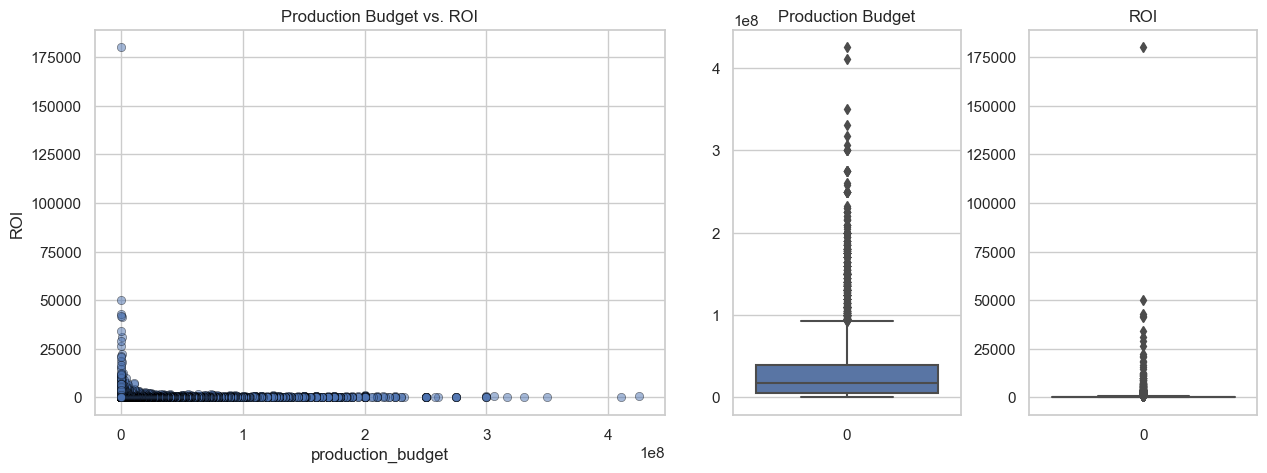

In [922]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), width_ratios=[2.5, 1, 1])

sns.set(style="whitegrid")

sns.scatterplot(data = budgetdf, x = 'production_budget', y = 'ROI', alpha=0.5, edgecolor='black', ax=ax[0])
sns.boxplot(budgetdf['production_budget'], ax=ax[1])
sns.boxplot(budgetdf['ROI'], ax=ax[2])

ax[0].set_title('Production Budget vs. ROI')
ax[1].set_title('Production Budget')
ax[2].set_title('ROI');

### What's wrong with this?

The plot is uninterpretable becasue of the presence of several outliers along the extremes of the x- and y-axis. The two boxplots of budget and ROI on the right confirm this. We need to remove these outliers somehow. The best way to do this is to map both production_budget and ROI columns over a function that turns a value into **nan** if it's an outlier, and then call the .dropna() method on our dataframe.

We will use the IQR (interquartile range) to locate outliers. Initially we multiply the IQR by 1.5 and locate the 25th quartile (Q1) and 75th quartile (Q3). Q1 and Q3 show up on the boxplot as the edges of the box parallel to the median. Any value less than Q1 - (IQR * 1.5) is an outlier; likewise for any value greater than Q3 + (IQR * 1.5).

In [923]:
def is_outlier(x, df):
    """
    This function takes a value and its associated
    group of values as its arguments. It determines whether
    or not the value is an outlier in its dataset; if it is,
    it returns a null value. If not, it returns the original value.
    """

    q1, q3 = df.quantile([.25, .75])
    iqr = q3-q1
    
    lower_limit = q1 - (iqr*1.5)
    upper_limit = q3 + (iqr*1.5)
    
    if any([(x<lower_limit), (x>upper_limit)]):
        return np.nan
    else:
        return x

In [924]:
# Number of rows pre-cleaning
print("The previous dataframe had {} rows.\n".format(budgetdf.shape[0]))


to_clean = [
    'production_budget',
    'worldwide_gross',
    'ROI'
]

for i in to_clean:
    budgetdf[i] = budgetdf[i].map(lambda x: is_outlier(x, budgetdf[i]))


# This shows us how many 'outliers' are in each column. 
for i in to_clean:
    print(budgetdf[i].isnull().value_counts())
    
budgetdf.dropna(inplace=True)

# If this command isn't executed, Seaborn will return an error on subsequent boxplots
budgetdf = budgetdf.reset_index(drop=True)


# Number of rows post-cleaning
print("\nThe current dataframe has {} rows.".format(budgetdf.shape[0]))

The previous dataframe had 5782 rows.

False    5351
True      431
Name: production_budget, dtype: int64
False    5178
True      604
Name: worldwide_gross, dtype: int64
False    5287
True      495
Name: ROI, dtype: int64

The current dataframe has 4695 rows.


Text(0.5, 1.0, 'ROI boxplot')

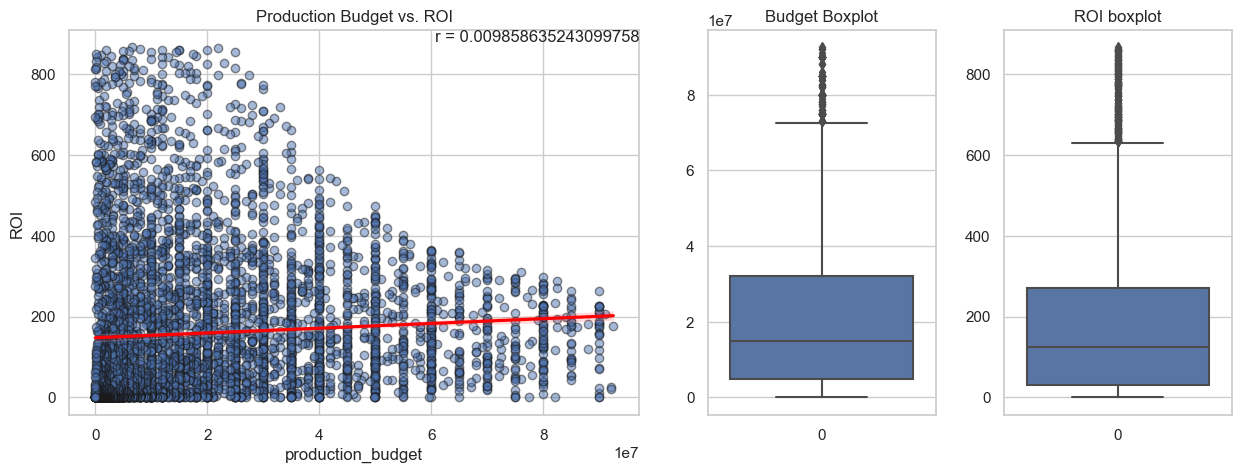

In [925]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), width_ratios=[2.5, 1, 1])

# Using seaborn's regression plot to include a trendline
sns.regplot(data = budgetdf, x = 'production_budget', y = 'ROI',
            robust=True, ax=ax[0],
            scatter_kws={'alpha': 0.5, 'edgecolor': 'k'},
            line_kws={'color': 'red'})

sns.boxplot(budgetdf['production_budget'], ax=ax[1])
sns.boxplot(budgetdf['ROI'], ax=ax[2])

# Calculating the correlation so we can annotate the graph with it
correlation = np.corrcoef(budgetdf['production_budget'], budgetdf['ROI'])[0][1]
ax[0].annotate('r = {}'.format(correlation), xy=(1,1), xycoords='axes fraction', ha='right', va='top')

ax[0].set_title('Production Budget vs. ROI')
ax[1].set_title('Budget Boxplot')
ax[2].set_title('ROI boxplot')

### Conclusion

The outliers are mostly gone, as you can see from both the scatterplot and the boxplots. The scatterplot looks much cleaner and is visually interpretable. Although there are no data points in the top diagonal half of the scatterplot, the data points are otherwise evenly distributed across the axes with no apparent correlation. The trendline and the r value (close to 0) strongly suggest that there is no correlation between budget and ROI.

# Budget Data – Correlation with Profitability

It's hard to believe that budget bears no correlation with success whatsoever, so what if we try looking at this differently? What if we measure the correlation between budget and our boolean **profitable** variable? Remember, this variable is **True** when ROI > 100, and **False** when ROI <= 100.

Visualizing the interaction between these two variables is going to be more challenging, since **profitable** is a boolean while **budget** is continuous. I will divide budget into multiple tiers, and then calculate the hitrate of the movies in each of these tiers (hitrate being the percentage of these movies that are profitable). The idea is that if a tier has a higher hitrate, that means a movie is more likely to succeed with a budget in that tier.

In [926]:
# Creating the boolean column
budgetdf['profitable'] = budgetdf['ROI'].map(lambda x: True if x > 100 else False)

In [927]:
# The number of bins we split budget into
num_bins = 10

# Creating the endpoints for our ranges
budget_range = np.linspace(0, 
                           budgetdf['production_budget'].max(),
                           num_bins, dtype=int)
budget_range

array([       0, 10277777, 20555555, 30833333, 41111111, 51388888,
       61666666, 71944444, 82222222, 92500000])

In [928]:
# Creating neatly formatted strings for our ranges
tierstrings = [str(round(i/1000000, 1)) + ' million' for i in budget_range]
tierranges = ["{} – {}".format(tierstrings[i], tierstrings[i+1]) for i in range(len(tierstrings)-1)]

tierranges[0]

'0.0 million – 10.3 million'

In [929]:
# Creating the budget category column for our dataframe
money_range = pd.cut(budgetdf['production_budget'], bins=budget_range, labels=tierranges)
budgetdf['budget_category'] = money_range.astype(object)

budgetdf.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,profitable,budget_category
0,32,"Feb 14, 2008",The Spiderwick Chronicles,92500000.0,71195053,162839667.0,176.042883,True,82.2 million – 92.5 million


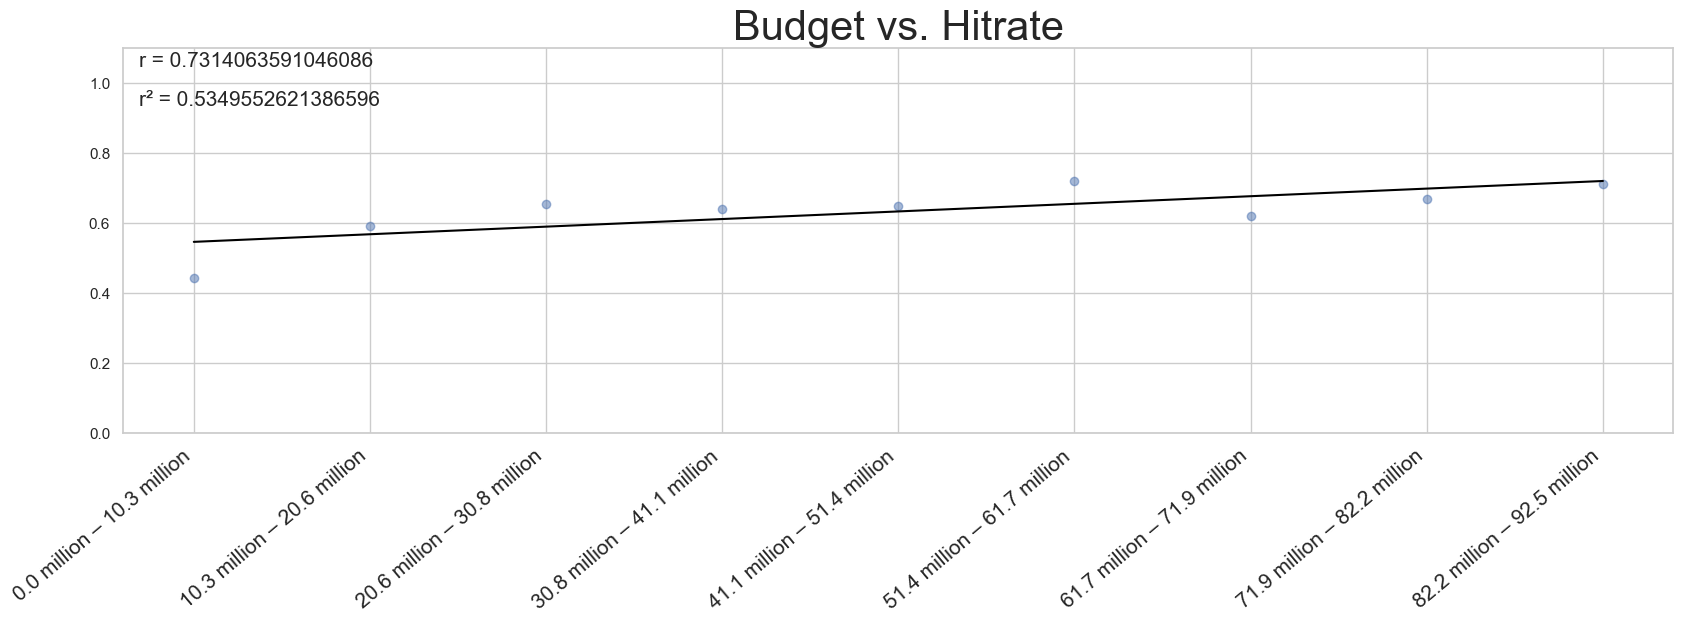

In [930]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title("Budget vs. Hitrate", fontsize=30)

# Setting data variables
x = tierranges
y = [budgetdf[budgetdf['budget_category'] == i].mean(numeric_only=True)['profitable'] for i in tierranges]

# Setting y limit to make the visualization more realistic
ax.set_ylim(0,1.1)

# Rotating x labels to make them readable
plt.xticks(rotation = 40, horizontalalignment='right', fontsize=15)


# Regression line code
# Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
z = list(range(0, len(x)))
b, a = np.polyfit(z, y, deg=1)
xseq = np.linspace(min(z), max(z), num=100)
ax.plot(xseq, a + b * xseq, color="black", lw=1.5);

# This is the Pearson correlation coefficient between our x and y variable
# Correlation line comes from https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
correlation = np.corrcoef(z,y)[0,1]

# Annotating the correlation
ax.text(.01,
         .99, 
         "r = {}".format(str(correlation)),
         ha='left',
         va='top',
         transform=ax.transAxes,
         fontsize = 15)

ax.text(.01,
         .89, 
         "r² = {}".format(str(correlation**2)),
         ha='left',
         va='top',
         transform=ax.transAxes,
         fontsize = 15)

ax.scatter(x,y,alpha=0.5);

### Conclusion
Although there appears to be no correlation between budget and ROI, further investigation suggests a possible correlation between budget and whether or not a movie is profitable. In the graph above, the percentage of profitable movies steadily increases as budget goes up. Movies in the lowest budget tier are profitable less than 40% of the time, whereas movies in the top four budget tiers are all above 60%. The regression line and correlation coefficient also support this conclusion, with the best-fitting line having a correlation coefficient of 0.63.

# Recommendation
We did not have enough data for movies above 100 million in budget to make a recommendation on those. However, for movies under 100 million dollars in budget, we found that increasing budget leads to a reliable increase in movie success rate. We recommend –

# Genre – Data Collecting & Cleaning

Our biggest and best set of genre data comes from the im.db dataset. However, this dataset does not contain budget or gross information; if we want to measure the effects of genre on ROI or profitability, we will have to join several tables.

In [931]:
q = """
SELECT movie_basics.movie_id,
       budgetdf.release_date,
       movie_basics.genres,
       movie_basics.runtime_minutes,
       budgetdf.movie,
       budgetdf.production_budget,
       budgetdf.domestic_gross,
       budgetdf.worldwide_gross,
       budgetdf.ROI,
       budgetdf.profitable,
       budgetdf.budget_category

FROM budgetdf
JOIN movie_basics
    ON movie = primary_title
"""

genredf = pysqldf(q)

In [932]:
genredf.head(1)

,movie_id,release_date,genres,runtime_minutes,movie,production_budget,domestic_gross,worldwide_gross,ROI,profitable,budget_category
0,tt0359950,"Dec 25, 2013","Adventure,Comedy,Drama",114.0,The Secret Life of Walter Mitty,91000000.0,58236838,187861183.0,206.44086,1,82.2 million – 92.5 million


In [933]:
genredf.movie_id.value_counts().value_counts() # There are 2902 unique movies and 84 duplicates

1    2902
2      84
Name: movie_id, dtype: int64

In [934]:
genredf.movie_id.value_counts()

tt1321509    2
tt4463894    2
tt5112932    2
tt3276924    2
tt2039338    2
            ..
tt1954974    1
tt2063008    1
tt2346048    1
tt4621482    1
tt2107644    1
Name: movie_id, Length: 2986, dtype: int64

In [935]:
genredf[genredf.movie_id == 'tt3276924']

,movie_id,release_date,genres,runtime_minutes,movie,production_budget,domestic_gross,worldwide_gross,ROI,profitable,budget_category
656,tt3276924,"Nov 9, 2001","Action,Crime,Thriller",93.0,Heist,35000000.0,23483357,28906817.0,82.590906,0,30.8 million – 41.1 million
1951,tt3276924,"Nov 13, 2015","Action,Crime,Thriller",93.0,Heist,8900000.0,50136,3324131.0,37.349787,0,0.0 million – 10.3 million


In [936]:
genredf[genredf.movie_id == 'tt1321509']

,movie_id,release_date,genres,runtime_minutes,movie,production_budget,domestic_gross,worldwide_gross,ROI,profitable,budget_category
1138,tt1321509,"Apr 16, 2010",Comedy,92.0,Death at a Funeral,21000000.0,42739347,48977233.0,233.224919,1,20.6 million – 30.8 million
1229,tt1321509,"Aug 17, 2007",Comedy,92.0,Death at a Funeral,20000000.0,8580428,46790428.0,233.952140,1,10.3 million – 20.6 million


It looks like the 'duplicate' entries contain conflicting data. It's clear we have to remove them.

In [937]:
q = """
SELECT * FROM genredf
WHERE movie_id NOT IN (SELECT movie_id
                       FROM genredf
                       GROUP BY movie_id
                       HAVING COUNT(*)>=2)
"""

genredf = pysqldf(q)

In [938]:
genredf.movie_id.value_counts().value_counts() # The 84 duplicate entries are now gone

1    2902
Name: movie_id, dtype: int64

# Genre – Correlation with profitability

The most obvious question to ask is: which genres correlate most highly with ROI? To answer, we need to extract a list of all the genres available in our dataset. Once we do, we need to create a boolean column for each genre whose value is 1 if a movie is in that genre and 0 if not.

Those columns will be used to create a boolean table that is used to create a correlation matrix, which will be used to create a heatmap with the seaborn package. This heatmap will provide an easy visual method of identifying strong/weak correlations.

In [939]:
# Extracting list of unique genres

genres = (list(genredf['genres'].unique()))
genres.remove(None) # Removing Nonetypes from the list
genres = ",".join(genres)
genres = genres.split(",")
genres = sorted(list(set(genres)))

genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [940]:
# Eliminating null values from genres column
genredf['genres'] = genredf['genres'].map(lambda x: 'None' if not x else x)

In [941]:
# Creating dataframe for boolean columns
genrebooldf = pd.DataFrame()

# Populating boolean dataframe
for i in genres:
    genrebooldf["is_"+i] = genredf['genres'].map(lambda x: True if i in x else False)
    
# Adding profitable column to boolean dataframe
genrebooldf['profitable'] = genredf['profitable']

In [942]:
genrebooldf

,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,...,is_Mystery,is_News,is_Reality-TV,is_Romance,is_Sci-Fi,is_Sport,is_Thriller,is_War,is_Western,profitable
0,False,True,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
4,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0
2898,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2899,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0
2900,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,0


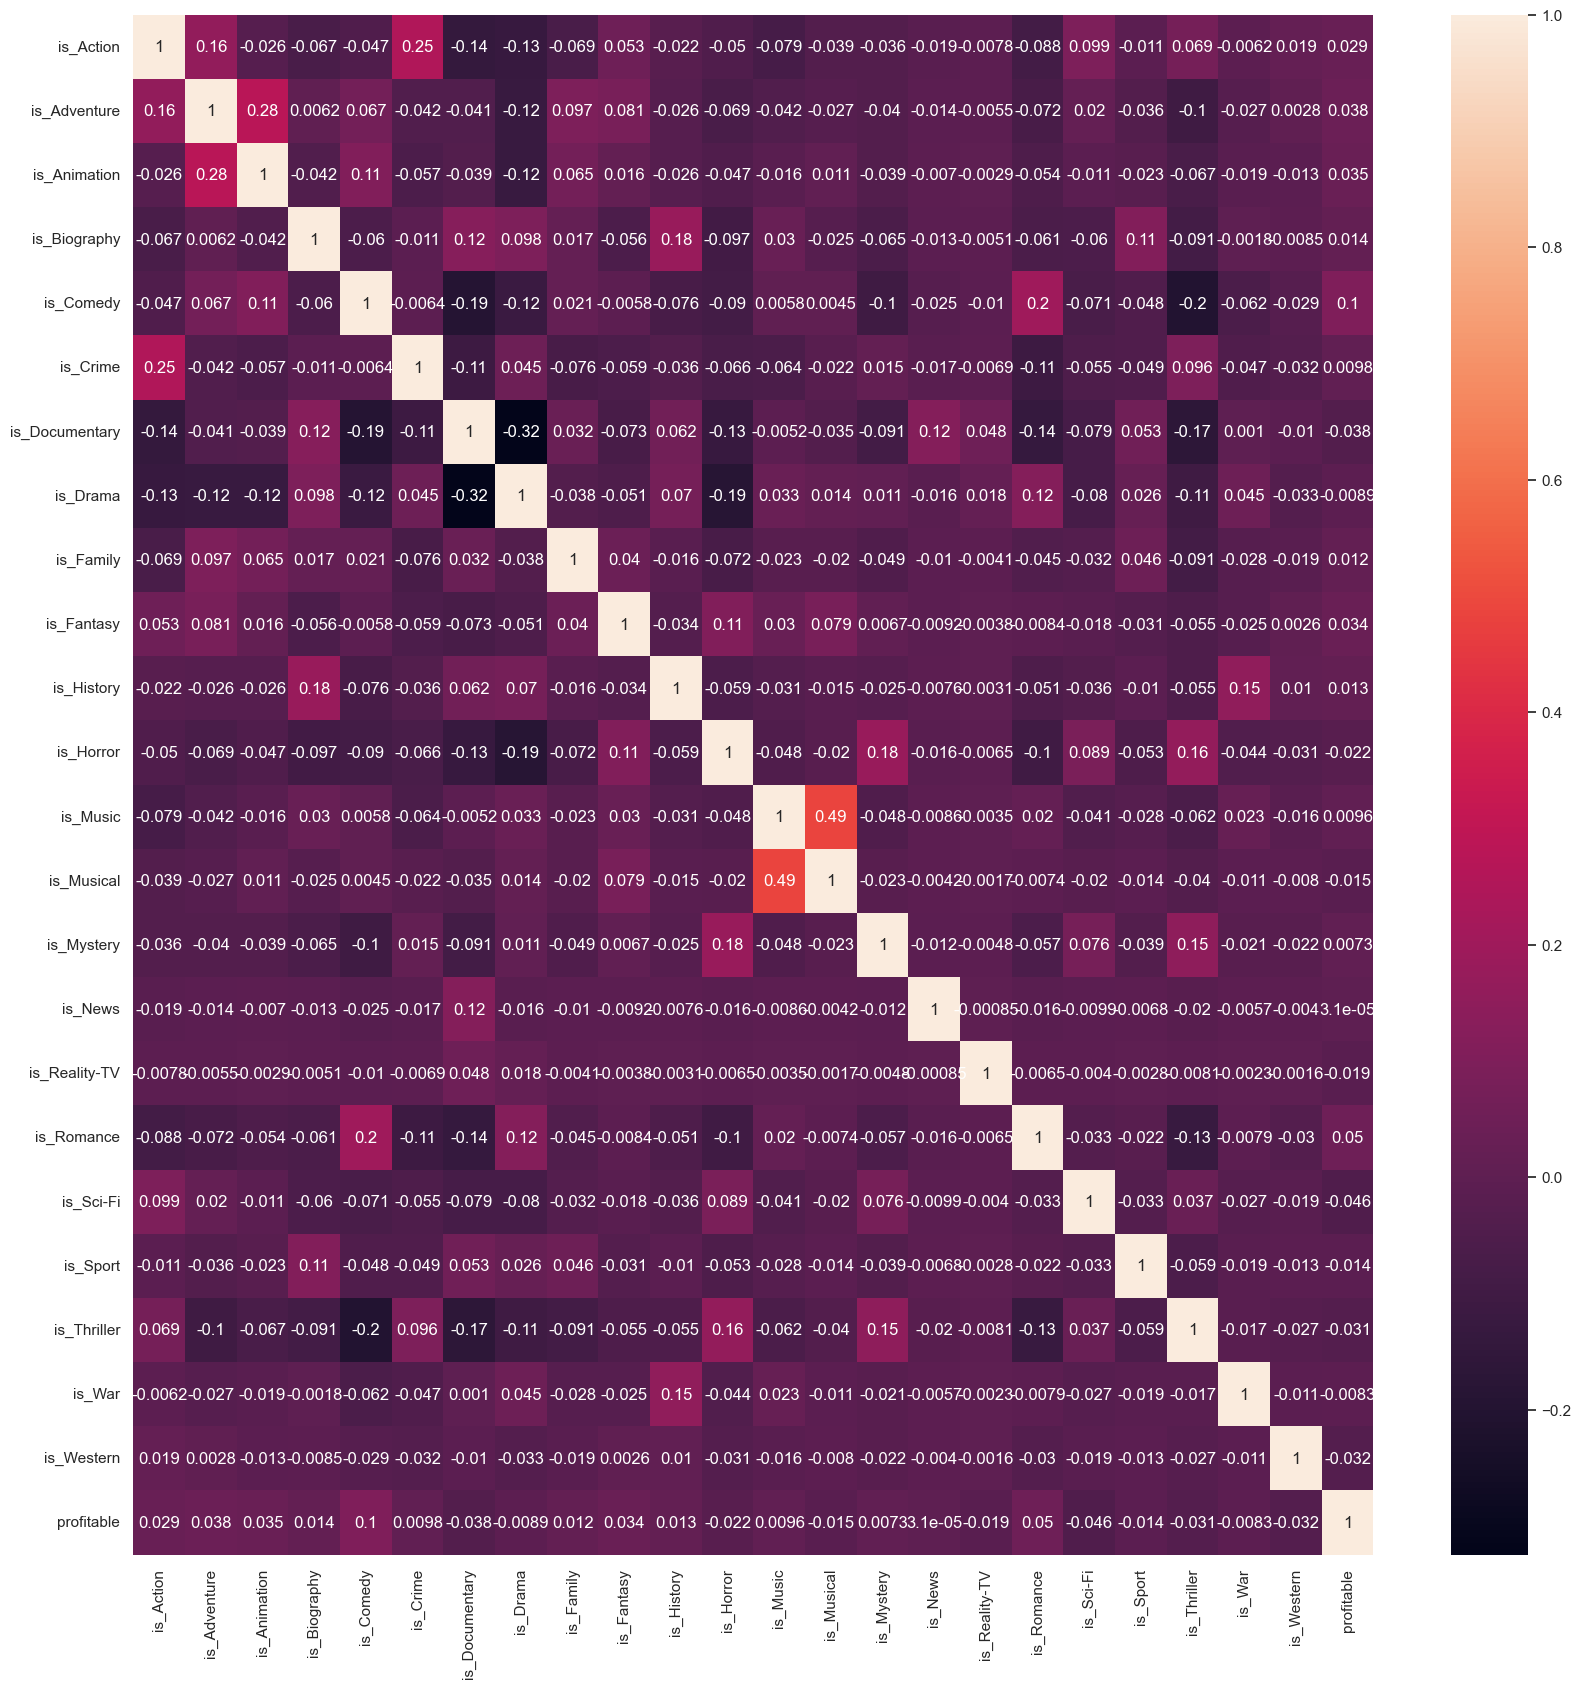

In [943]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(genrebooldf.corr(), ax=ax, annot=True);

In [944]:
genrebooldf.corr().sort_values('profitable', ascending=False)['profitable']

profitable        1.000000
is_Comedy         0.100350
is_Romance        0.050090
is_Adventure      0.037882
is_Animation      0.034523
is_Fantasy        0.033701
is_Action         0.029168
is_Biography      0.013669
is_History        0.012899
is_Family         0.011686
is_Crime          0.009767
is_Music          0.009621
is_Mystery        0.007338
is_News           0.000031
is_War           -0.008280
is_Drama         -0.008949
is_Sport         -0.013975
is_Musical       -0.015157
is_Reality-TV    -0.018554
is_Horror        -0.021760
is_Thriller      -0.030644
is_Western       -0.031722
is_Documentary   -0.037570
is_Sci-Fi        -0.046494
Name: profitable, dtype: float64

### Conclusion

There are no strong correlations *at all* from our last analysis. There was only one moderate correlation at best, and that was between comedy and profitability. And I'm not going to recommend that our stakeholders limit themsevles to the comedy genre!

# Genre – Correlation with profitability (2nd approach)

We should approach this differently. What if we measured the hitrate (rate of profitability) of movies three times for each genre: once when the genre is present, once when it is absent, and once across both states (average hitrate), and compared all three hitrates?

For this visualization, I am also going to calculate error bars with the standard error (standard deviation of sample divided by sample size).

In [945]:
# This list will contain:
# average hitrate, hitrate with the genre, hitrate without the genre,
# and the std/sample sizes necessary to calculate the standard errors for all three of those.
data=[]

In [946]:
import math

# Average hitrate here
average = len(genrebooldf[genrebooldf.profitable == 1])/\
          len(genrebooldf)

for i in range(len(genres)):
    stds = []
    roots = []
    
    genre = genres[i]
    colname = "is_" + genre
    
    # Hitrate with genre
    on = len(genrebooldf[(genrebooldf[colname]==1) & (genrebooldf.profitable==1)])/\
         len(genrebooldf[(genrebooldf[colname]==1)])
    
    # Hitrate without genre
    off = len(genrebooldf[(genrebooldf[colname]==0) & (genrebooldf.profitable==1)])/\
          len(genrebooldf[(genrebooldf[colname]==0)])
    
    stds.append(np.std(genrebooldf)['profitable'])
    stds.append(np.std(genrebooldf[(genrebooldf[colname]==0)])['profitable'])
    stds.append(np.std(genrebooldf[(genrebooldf[colname]==1)])['profitable'])
    
    sample_size_1 = len(genrebooldf)
    sample_size_2 = len(genrebooldf[(genrebooldf[colname]==0)])
    sample_size_3 = len(genrebooldf[(genrebooldf[colname]==1)])
    
    roots.append(math.sqrt(sample_size_1))
    roots.append(math.sqrt(sample_size_2))
    roots.append(math.sqrt(sample_size_3))
    
    # Appending to main list
    data.append([[average, off, on], stds, roots])

In [947]:
data[0]

[[0.4996554100620262, 0.4935064935064935, 0.5342465753424658],
 [0.49999988125776057, 0.4999578325953288, 0.498825793315976],
 [53.87021440462252, 49.63869458396343, 20.92844953645635]]

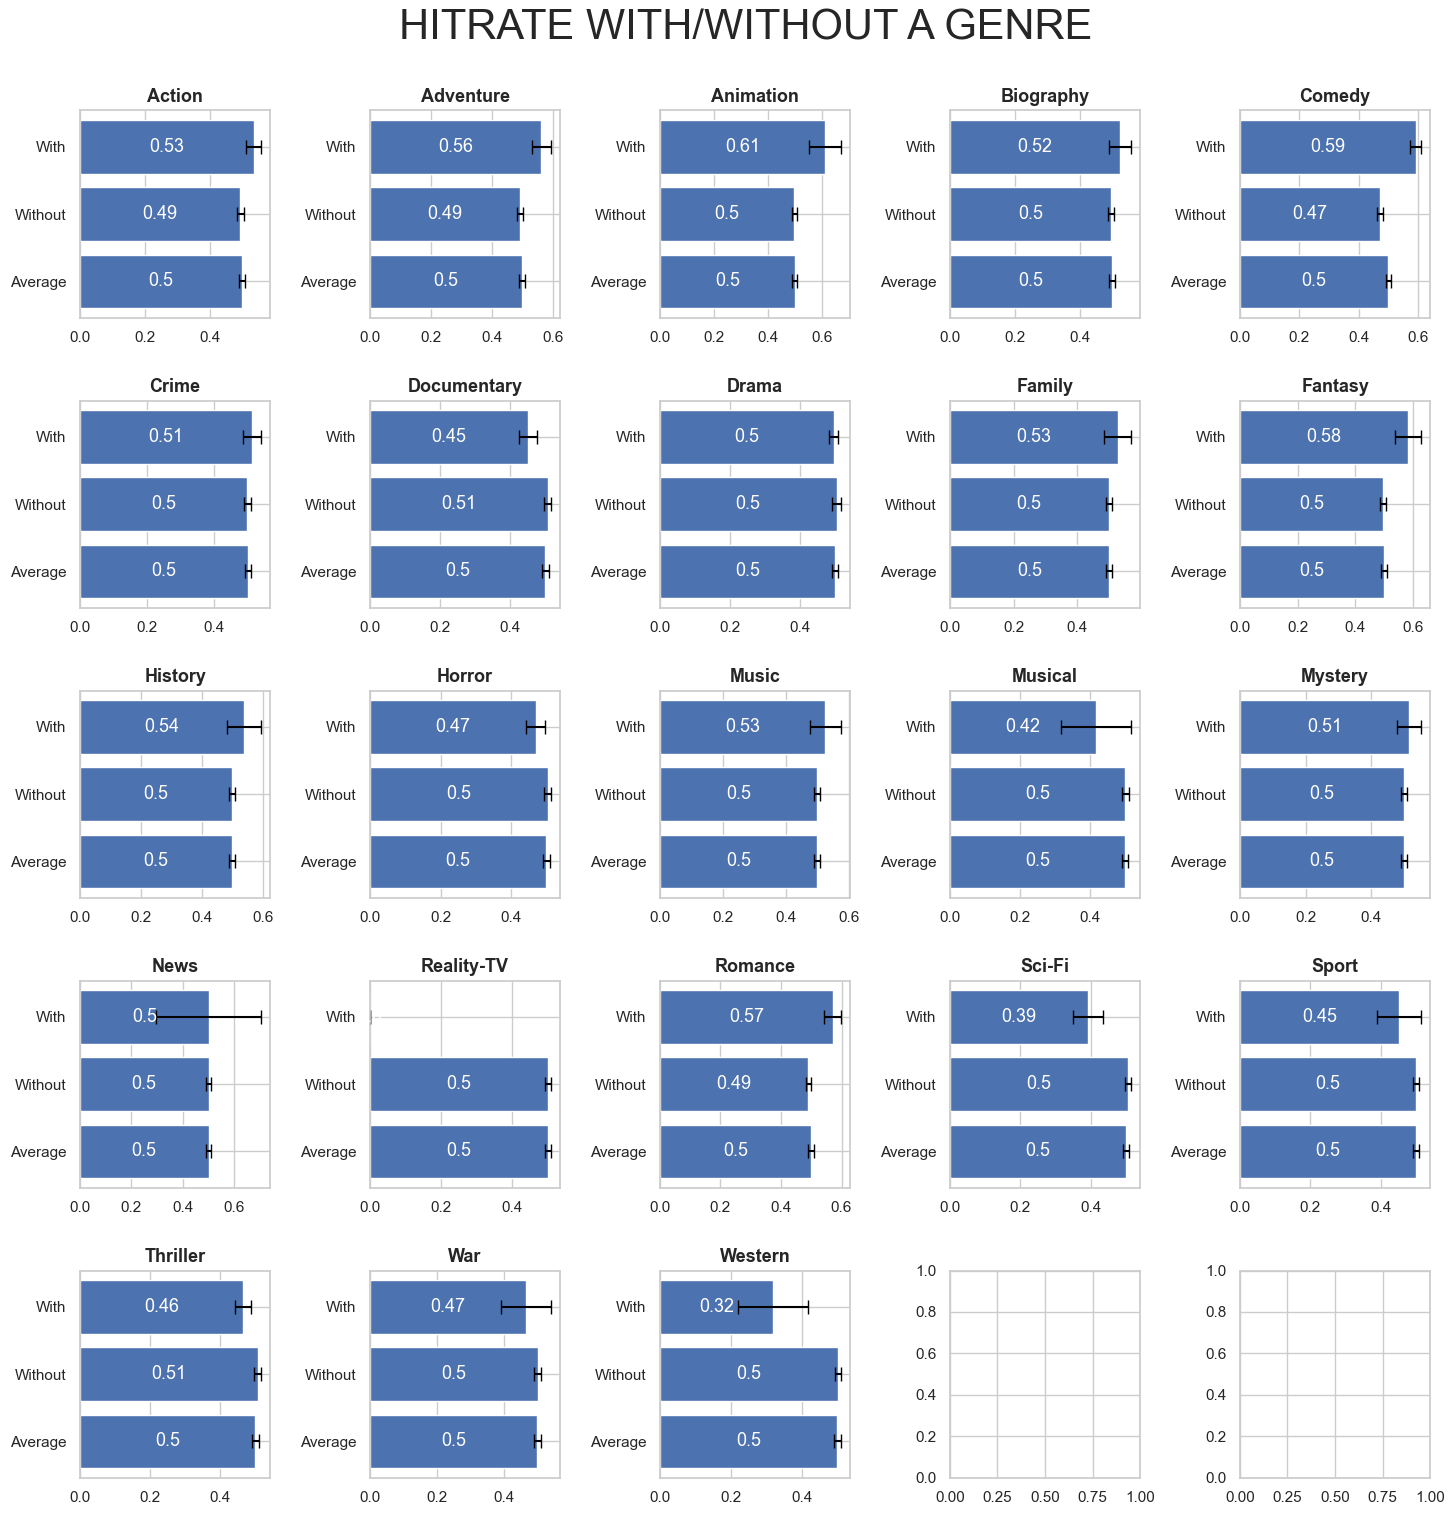

In [948]:
# Creating our visualization

rows = 5
cols = 5

fig, ax = plt.subplots(rows,cols, figsize=(15,15))
fig.tight_layout(pad=3) # Spacing out individual axes
fig.suptitle("HITRATE WITH/WITHOUT A GENRE", y=1.03, fontsize=30)

for i in range(rows*cols):
    
    # There are 25 axes but the number of genres is fewer;
    # The try-except will try to populate cells until there are no more genres left,
    # at which point the except clause will catch an error and end the loop

    try:
        # These two variables make the coordinates for the axis
        row = i//rows
        col = i%rows

        x = ['Average', 'Without', 'With']
        y = data[i][0]
        ylabels=[round(i,2) for i in y]

        title = "{}".format(genres[i])
        ax[row,col].set_title(title, fontsize='13', weight='bold')
        
        # Calculates standard error by:
        # Dividing square root of sample size by standard deviation
        stds = [x[1] for x in data][i]
        roots = [x[2] for x in data][i]
        errorbars = [stds[x]/roots[x] for x in range(len(stds))]

        barplot = ax[row,col].barh(x,y, xerr=errorbars, ecolor='black', capsize=5)
        ax[row,col].bar_label(barplot, labels=ylabels, label_type='center', color='white', fontsize='13');
    except:
        break

### Conclusion

Of all the genres, these are the ones that stand out as more profitable:

- Action
- Adventure
- Animation
- Comedy
- Family
- Fantasy
- History
- Music
- Romance

... with Adventure, Animation, and Fantasy being by far the most profitable genres.

It seems like there was no point to calculating the average hitrate, since the Without/Average categories are almost exactly the same for every single genre.


# Genre – Correlation with ROI

We've investigated the interaction between genre and profitability, but we should also know how it interacts with ROI. The visualization will be the same kind as our last one, except instead of plotting genre against profitability, we will plot it against ROI.

In [949]:
# Appending ROI column to our boolean dataframe
genrebooldf['ROI'] = genredf['ROI']

In [950]:
# This list will contain:
# average ROI, ROI with the genre, ROI without the genre,
# and the std/sample sizes necessary to calculate the standard errors for all three of those.
data2=[]

In [951]:
# Average ROI here
average = genrebooldf['ROI'].mean()

for i in range(len(genres)):
    stds = []
    roots = []
    
    genre = genres[i]
    colname = "is_" + genre
    
    # ROI with genre
    on = genrebooldf[(genrebooldf[colname]==1)]['ROI'].mean()
    
    # ROI without genre
    off = genrebooldf[(genrebooldf[colname]==0)]['ROI'].mean()
    
    stds.append(np.std(genrebooldf)['ROI'])
    stds.append(np.std(genrebooldf[(genrebooldf[colname]==0)])['ROI'])
    stds.append(np.std(genrebooldf[(genrebooldf[colname]==1)])['ROI'])
    
    sample_size_1 = len(genrebooldf)
    sample_size_2 = len(genrebooldf[(genrebooldf[colname]==0)])
    sample_size_3 = len(genrebooldf[(genrebooldf[colname]==1)])
    
    roots.append(math.sqrt(sample_size_1))
    roots.append(math.sqrt(sample_size_2))
    roots.append(math.sqrt(sample_size_3))
    
    # Appending to main list
    data2.append([[average, off, on], stds, roots])

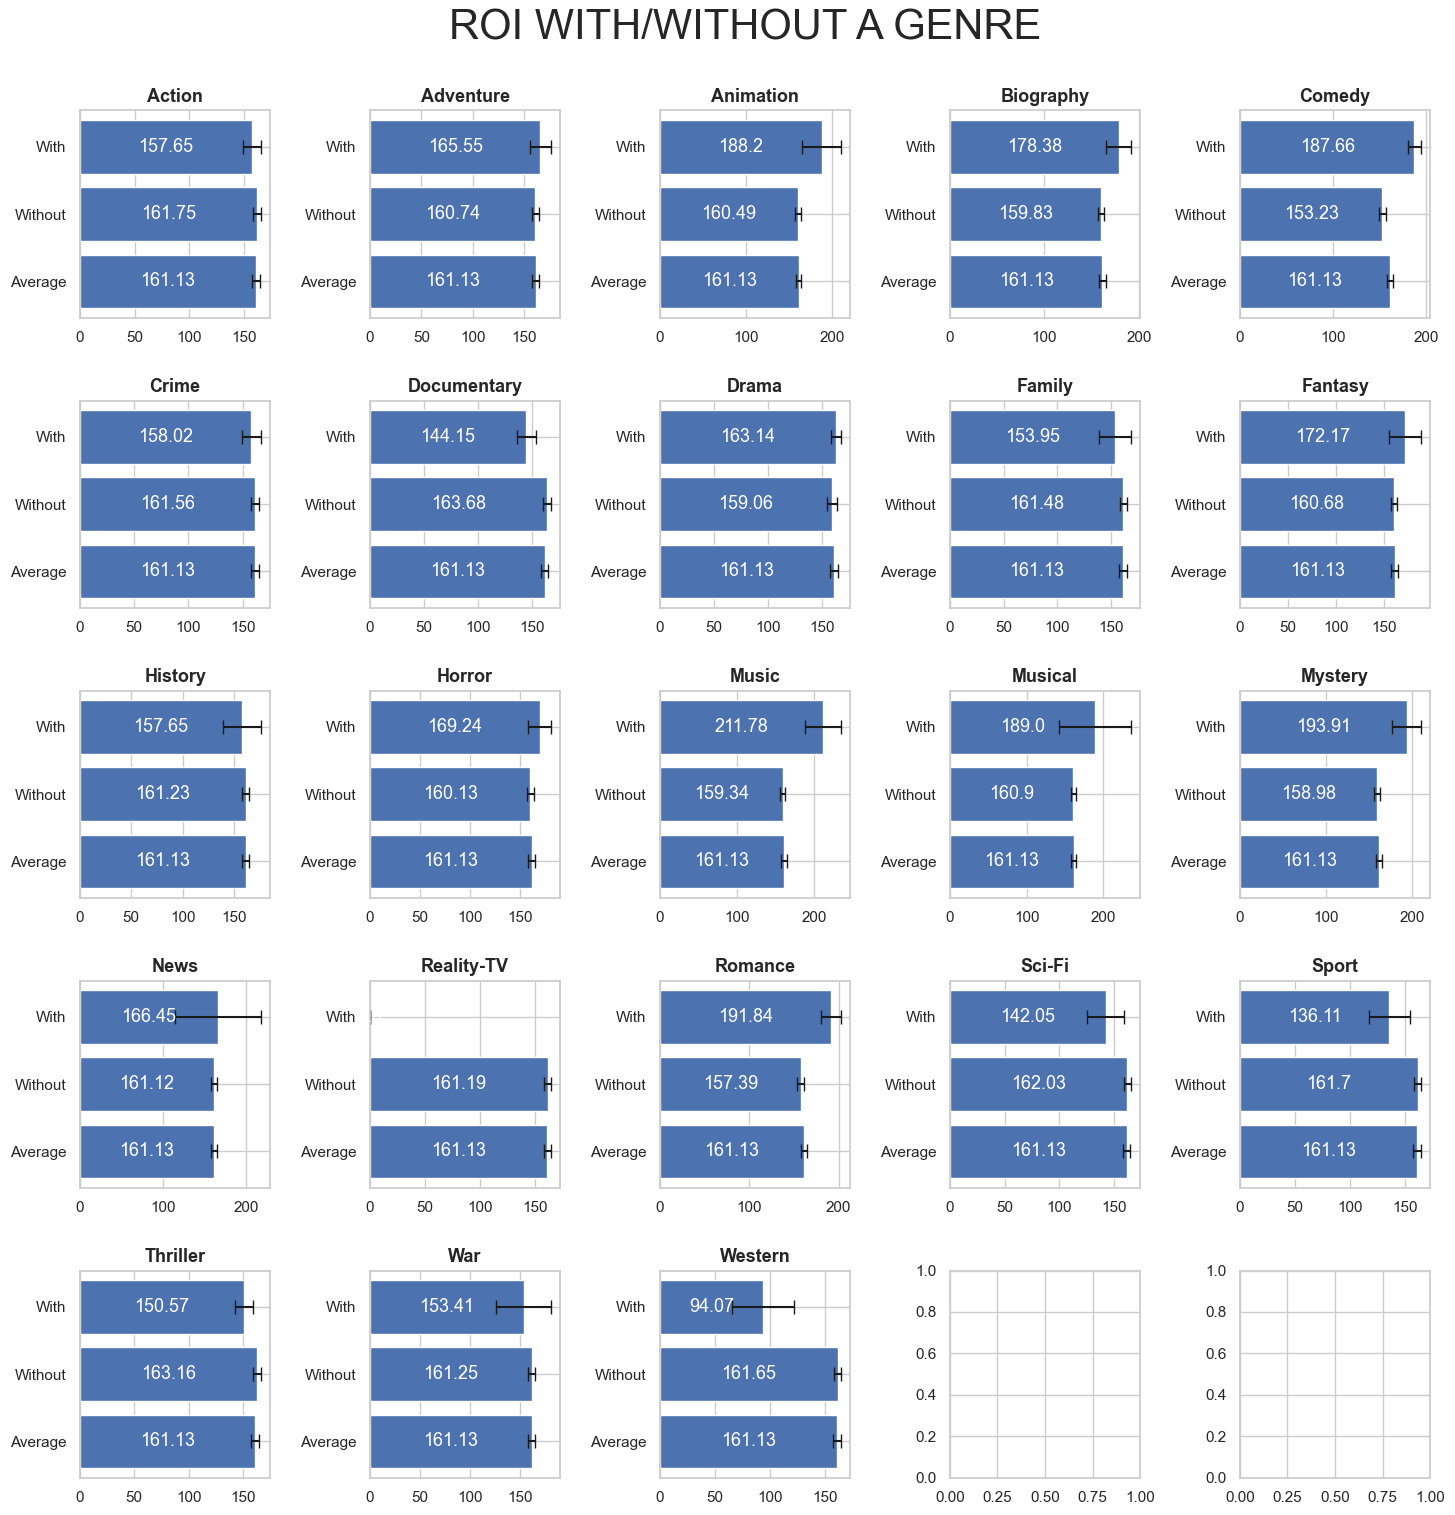

In [952]:
# Creating our visualization

rows = 5
cols = 5

fig, ax = plt.subplots(rows,cols, figsize=(15,15))
fig.tight_layout(pad=3) # Spacing out individual axes
fig.suptitle("ROI WITH/WITHOUT A GENRE", y=1.03, fontsize=30)

for i in range(rows*cols):
    
    # There are 25 axes but the number of genres is fewer;
    # The try-except will try to populate cells until there are no more genres left,
    # at which point the except clause will catch an error and end the loop
    
    try:
        # These two variables make the coordinates for the axis
        row = i//rows
        col = i%rows

        x = ['Average', 'Without', 'With']
        y = data2[i][0]
        ylabels=[round(i,2) for i in y]

        title = "{}".format(genres[i])
        ax[row,col].set_title(title, fontsize='13', weight='bold')
        
        # Calculates standard error by:
        # Dividing square root of sample size by standard deviation
        stds = [x[1] for x in data2][i]
        roots = [x[2] for x in data2][i]
        errorbars = [stds[x]/roots[x] for x in range(len(stds))]

        barplot = ax[row,col].barh(x,y,xerr=errorbars, capsize=5)
        ax[row,col].bar_label(barplot, labels=ylabels, label_type='center', color='white', fontsize='13');
        
    except:
        break

# Conclusion

Genres with ROIs that stand out are are:

- Animation
- Biography
- Comedy
- Music
- Mystery
- Romance

With the most profitable being animation, mystery, and music.

# Genre – Recommendation

# Cast – Data Collection & Cleaning

Look at the principals dataset below. It lists the entire cast for each movie, with details on their job in the movie and characters they play (if applicable). The dataset for this section should have similar data, with some added/re-arranged columns:

- person_id (from principals)
- primary_name (from persons)
- profession (from principals)
- movie_id (from our dataset in the last section)
- year (from our dataset in the last section)
- ROI (from our dataset in the last section)
- profitable (from our dataset in the last section)

We can eliminate the following columns, as they are no longer needed for analysis:

- runtime
- budget
- budget category
- all gross columns

In [970]:
q = """
SELECT person_id,
       primary_name AS name,
       category AS profession,
       movie_id,
       release_date AS year,
       ROI,
       profitable

FROM genredf
JOIN principals
    USING(movie_id)
JOIN persons
    USING(person_id)
"""

castdf = pysqldf(q)

In [971]:
castdf.head(3)

,person_id,name,profession,movie_id,year,ROI,profitable
0,nm0001774,Ben Stiller,actor,tt0359950,"Dec 25, 2013",206.44086,1
1,nm0175726,Steve Conrad,writer,tt0359950,"Dec 25, 2013",206.44086,1
2,nm0180366,Stuart Cornfeld,producer,tt0359950,"Dec 25, 2013",206.44086,1


In [972]:
# Re-formatting date column as an integer
castdf['year'] = castdf['year'].map(lambda x: int(x[-4:]))

# Cast – Choice of Profession

For the questions in this section, we will focus on the following professions:

- Actors
- Actresses
- Directors
- Producers
- Writers

As you can see from the list below, we are choosing to ignore the following professions:

- Composers
- Editors
- 'Self' (?)
- Cinematographers
- Production designers
- Archive_footage

In [976]:
professions = list(castdf['profession'].unique())
professions

['actor',
 'writer',
 'producer',
 'composer',
 'actress',
 'director',
 'editor',
 'self',
 'cinematographer',
 'production_designer',
 'archive_footage']

In [1071]:
# Updating professions list
professions = ['actor', 'actress', 'director', 'producer', 'writer']

# Cast – Predictive Questions

In this section, we will find out the impact each profession has on a movie's success. We can approach this in four different ways:

- Impact of profession's ROI on movie's ROI
- Impact of profession's ROI on movie's hitrate
- Impact of profession's hitrate on movie's ROI
- Impact of profession's hitrate on movie's hitrate

Each of these questions is a predictive question, and cannot be done with a single dataset. In order to answer any of these, we will have to **split** our dataset into two parts, along a particular **year**. We will then find out how well a variable in the first dataset correlates with a variable in the second dataset. This can give us at least some idea of any underlying causal relationships.

The idea is: if you were to select people in a profession based on one of their attributes, and make a movie with these people, what are the chances of your movie succeeding? Splitting our dataset down a year and comparing values is as close as we can come to answering this question.

In [1000]:
years = sorted(castdf.year.unique())
len(years)

61

We have 61 years to work with. (That's a lot!)

When you split down a year, you want as many people in common between the two datasets as possible. Even if you have 5000 people in one and 5000 people in the other, what good does that do if none of the people from the first are in the second?

We need to maximize the number of people **in common** between the two datasets.

In [1321]:

for i in years:
    
    persons_set_1 = set(castdf[castdf.year<=i].person_id.unique()) # Unique people in first dataset
    persons_set_2 = set(castdf[castdf.year>i].person_id.unique()) # Unique people in second dataset
                        
    print(
        str(i) + ": ",
        len((persons_set_1).intersection(persons_set_2)) # Number of unique people in common between datasets
    )

1927:  1
1931:  2
1940:  2
1944:  5
1945:  7
1948:  8
1950:  12
1951:  20
1956:  25
1959:  32
1960:  35
1961:  39
1964:  39
1965:  41
1966:  42
1967:  47
1972:  48
1974:  54
1976:  56
1979:  57
1980:  62
1981:  70
1982:  70
1983:  83
1984:  90
1985:  92
1986:  100
1987:  107
1988:  114
1989:  117
1990:  118
1991:  130
1992:  137
1993:  147
1994:  176
1995:  198
1996:  215
1997:  223
1998:  250
1999:  285
2000:  321
2001:  352
2002:  363
2003:  382
2004:  390
2005:  408
2006:  424
2007:  436
2008:  438
2009:  455
2010:  933
2011:  1331
2012:  1539
2013:  1591
2014:  1517
2015:  1233
2016:  881
2017:  547
2018:  152
2019:  5
2020:  0


# Cast – Year Selection

This is quite the interesting view we have. It seems like 2013 mazimizes the number of people in common between the two datasets. However, years 2011-2015 all have over a thousand people and could be good candidates for analysis. We will still select 2013 as our year of choice.

In [1191]:
year = 2013

before = castdf[castdf.year <= year].copy() # All data before or during 2013
after = castdf[castdf.year > year].copy() # All data after 2013

In [1192]:
# Getting the list of people in common
intersection = set(before.person_id.unique()).intersection(set(after.person_id.unique()))
len(intersection)

1591

In [1193]:
# Reducing each dataset to only include people from the intersection
before = before[before.person_id.isin(intersection)]
after = after[after.person_id.isin(intersection)]

### Are the values in our datasets wildly different?

If so, any comparisons we make between the two might not be meaningful.

In [1194]:
attributes = ('ROI', 'profitable')

for a in attributes:
    for i in professions:
        mean1 = before[before.profession==i][a].mean()
        mean2 = after[after.profession==i][a].mean()
        print("{} average {}: {}, {}".format(i, a, mean1, mean2))
    
    print("\n")

actor average ROI: 193.29384452322944, 174.31507886332096
actress average ROI: 211.73974328597413, 200.11607272411302
director average ROI: 224.69837108559602, 203.1751448305032
producer average ROI: 209.13440598629543, 211.24092602715652
writer average ROI: 229.0096627764324, 214.26359736363435


actor average profitable: 0.6432681242807825, 0.5536992840095465
actress average profitable: 0.6510638297872341, 0.6
director average profitable: 0.6981818181818182, 0.6313725490196078
producer average profitable: 0.6525974025974026, 0.637593984962406
writer average profitable: 0.7101449275362319, 0.7288888888888889




It looks like the values aren't wildy different for either dataset; thankfully, they remain mostly similar. There are some exceptions, but mostly in the professions that we have chosen to ignore, so it isn't a major concern.

# Cast – Impact of profession's ROI on movie's ROI

We started off this section with a lot of questions, but we should only tackle one to begin with. Our strategy is as follows:

- Divide ROI into bins (e.g., between 200-300%, 400-500%, etc.)
- Find the people from the first dataset in each profession that fall into these bins
- Locate the same people in the second dataset and measure the success of the movies they're in
- Plot each ROI bin against movie success from the second dataset
- Measure the correlation and predictive power for each profession

In [1327]:
# This function queries data from both datasets and returns cetain data
# depending on the selection of profession and attributes

def query(profession, profession_attribute, movie_attribute):
    
    """
    docstring
    """
    
    ROIs = [] # List of movie ROIs per bin
    bins = [] # Bins denoted in string form
    
    # Creating local references to datasets for use within function
    beforelocal = before
    afterlocal = after
    
    # Creating bins based on whether selected attribute is ROI or profitable
    # ROI will have much higher values, profitable will only have values between 0 and 1
    if profession_attribute == "ROI":
        linspace = np.linspace(0,1000,21, dtype=int)
    elif profession_attribute == "profitable":
        linspace = np.linspace(0,1.01,20)
    else:
        return "Invalid profession attribute"
    
    for i in range(len(linspace)-1):

        # Gets all people from first dataset with ROI within a range
        q = """
        SELECT person_id
        FROM beforelocal
        GROUP BY person_id
        HAVING profession == '{}' AND AVG({})>{} AND AVG({})<{}
        """.format(profession, profession_attribute, linspace[i], profession_attribute, linspace[i+1])

        df1 = sqldf(q, locals())

        # Only gathering bins of a certain size to prevent misleading data
        if len(df1) < 5:
            continue

        # Retreiving data from the same people in the second dataset
        q2 = """
        SELECT *
        FROM afterlocal
        WHERE person_id IN (SELECT person_id FROM df1)
        """

        df2 = sqldf(q2, locals())

        # Appending the average ROI to our list
        ROIs.append(df2[movie_attribute].mean())

        # Creating the strings for each bin
        start = linspace[i]
        end = linspace[i+1]
        bins.append('{} – {}, [{} values]'.format(start, end, len(df1)))


    # Correlation
    correlation = np.corrcoef(range(0,len(ROIs)),ROIs)[0,1]

    # R Squared values (predictive power)
    rsquared = correlation**2
    
    return (profession,
           profession_attribute,
           movie_attribute,
           bins,
           ROIs,
           correlation,
           rsquared)

In [1247]:
# This function plots a graph based on the results of our data query function

def plot(data):
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    title = "{} {} as predictor of movie {}".format(data[0], data[1], data[2])
    ax.set_title(title, fontsize='20')
    
    x = data[3]
    y = data[4]
    
    # Sets limits of graph depending on the range of values available
    if max(y)>1:
        ax.set_ylim(0, 1000)
    else:
        ax.set_ylim(0,1)


    plt.xticks(
        rotation=65,
        horizontalalignment = 'right'
    )

    # Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
    b, a = np.polyfit(range(0,len(y)), y, deg=1)
    xseq = np.linspace(0, len(y), num=100)
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5);
    
    correlation = str(data[5])
    rsquared = str(data[6])

    ax.text(.01,
             .99, 
             "r = {}".format(correlation),
             ha='left',
             va='top',
             transform=ax.transAxes,
             fontsize = 15)
    
    ax.text(.01,
             .9, 
             "r² = {}".format(rsquared),
             ha='left',
             va='top',
             transform=ax.transAxes,
             fontsize = 15)
    
    ax.scatter(x, y);

# Cast – Putting it all together

We have defined two functions, a data query function and a plot function. We will now iterate through the list of professions we chose and plot average ROI vs movie ROI.

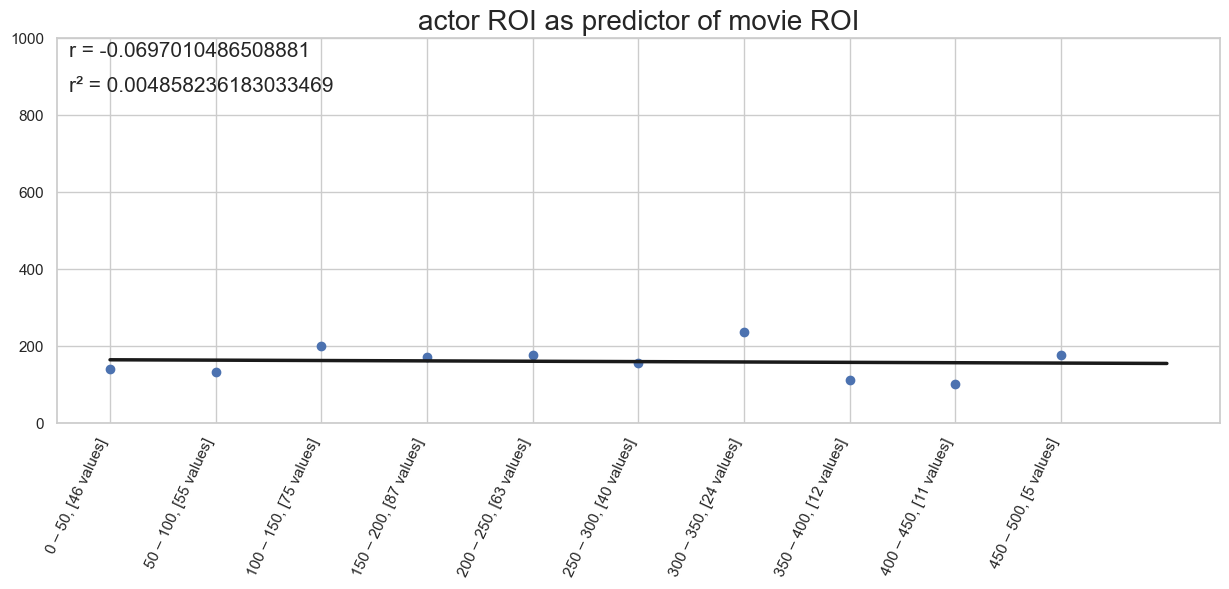

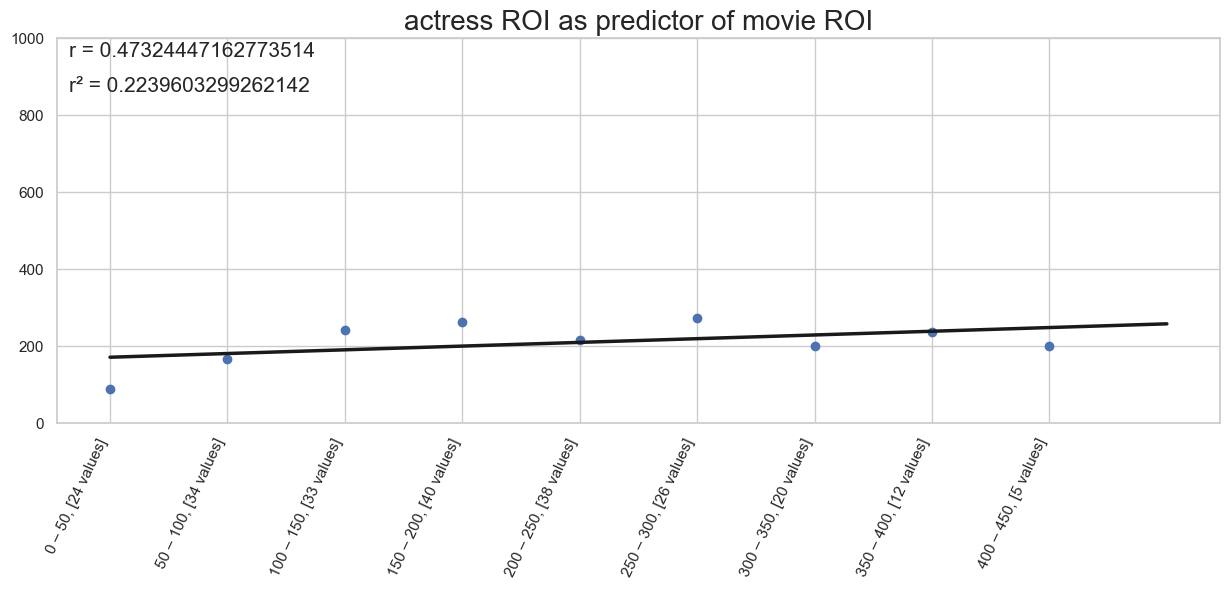

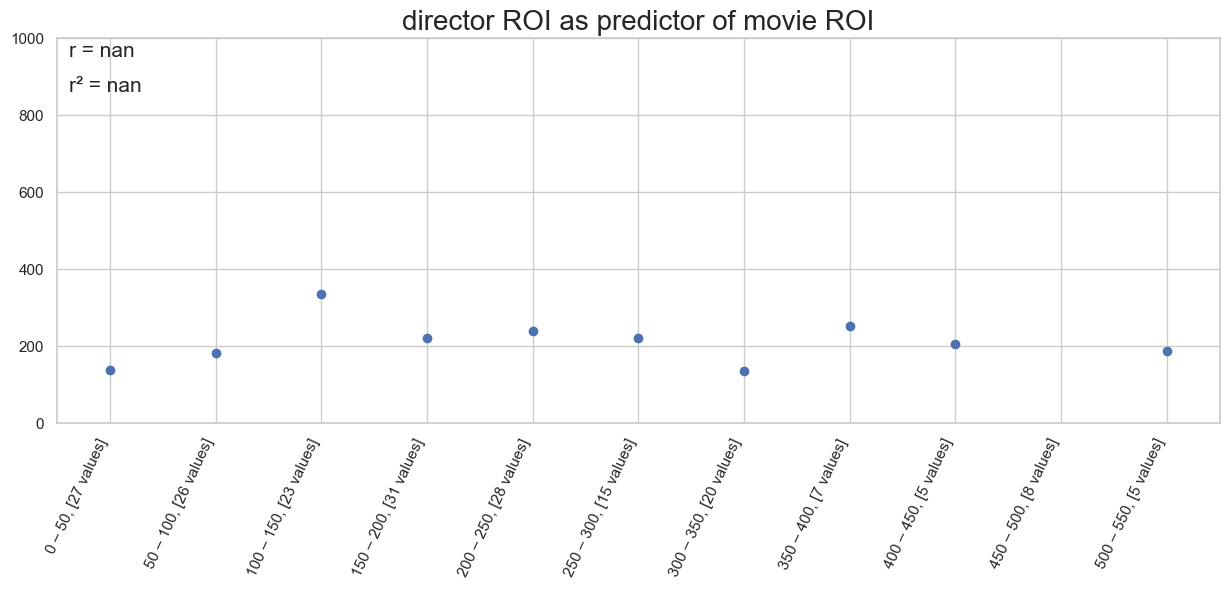

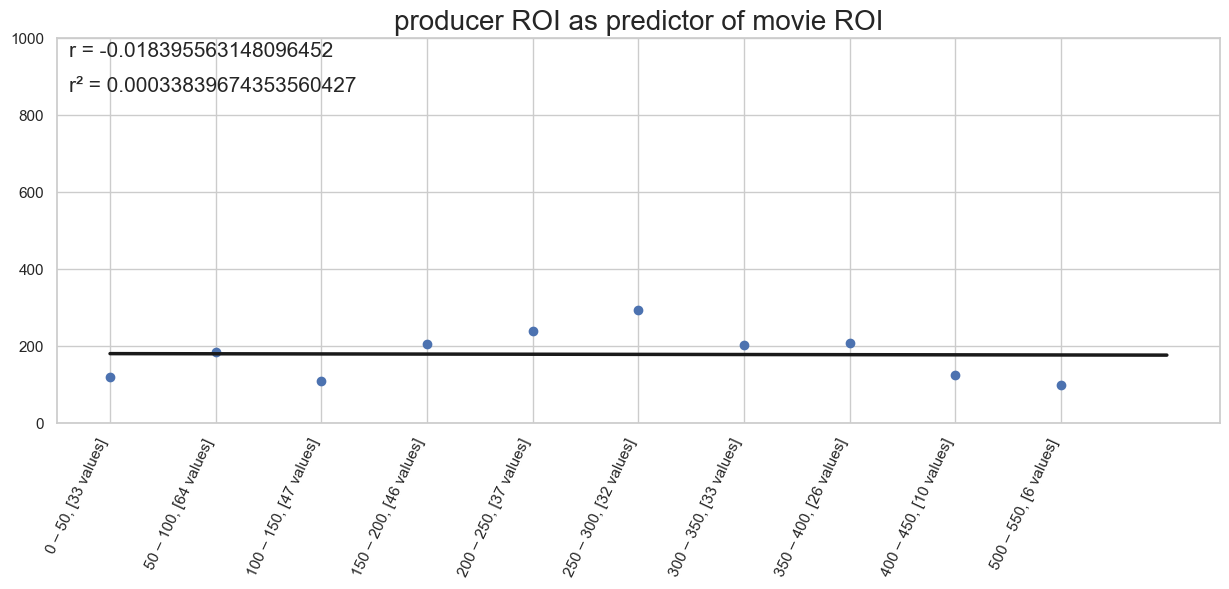

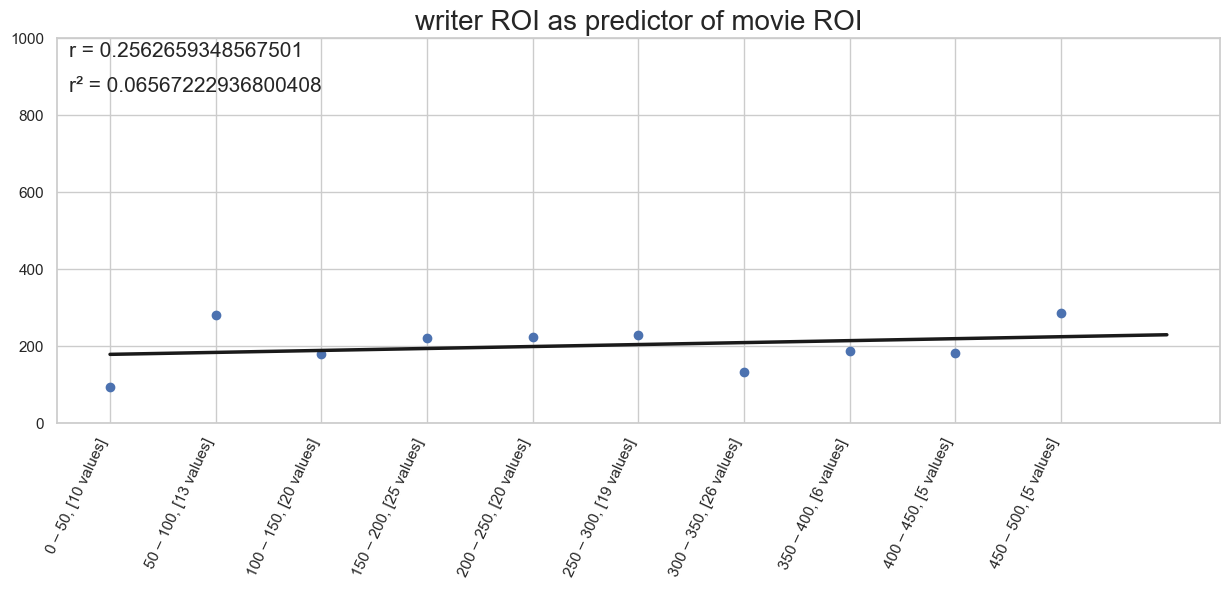

In [1347]:
for profession in professions:
    plot(query(profession, 'ROI', 'ROI'))

# Cast – Level Up: Average Correlation & Predictive Power Across Years

It's time to level this up. Not only are we going to answer the other three predictive questions, but we are also going to split across different years and re-answer the same questions. We will end up with a dataframe of correlations. We can then aggregate across years to get the average correlation with success and predictive power of success for each profession.

Let's also find the years that are acceptable candidates for answering these questions. Anything >500 can be used.

In [1323]:
years_updated = [] #New year list

for i in years:
    
    persons_set_1 = set(castdf[castdf.year==i].person_id.unique()) # Unique people in first dataset
    persons_set_2 = set(castdf[castdf.year==(i+1)].person_id.unique()) # Unique people in second dataset
    
    intersection = len((persons_set_1).intersection(persons_set_2)) # Number of unique people in common
    
    # Only select years with more than 500 people in common
    if intersection >= 100:
        years_updated.append(i)
    else:
        continue

In [1324]:
attributes = ['ROI', 'profitable']

profession = []
profession_attribute = []
movie_attribute = []


for p in professions:
    for a in attributes:
        for b in attributes:
            profession.append(p)
            profession_attribute.append(a)
            movie_attribute.append(b)

In [1325]:
data = {
    'profession': profession,
    'profession_attribute': profession_attribute,
    'movie_attribute': movie_attribute
}

In [1328]:
for year in years_updated:

    # Splitting our dataset down the year
    before = castdf[castdf.year <= year].copy()
    after = castdf[castdf.year > year].copy()
    
    # Getting the list of people in common
    intersection = set(dataset1.person_id.unique()).intersection(set(dataset2.person_id.unique()))
    len(intersection)

    # Reducing each dataset to only include people from the intersection
    before = before[before.person_id.isin(intersection)]
    after = after[after.person_id.isin(intersection)]
    
    # A column of correlations – reset and appended to dataset every loop
    column = []
    
    for p in professions:
        for a in attributes:
            for b in attributes:
                correlation = query(p, a, b)[5] # Retrieves correlation from query
                column.append(correlation)
    
    data[year] = column
    
    print("Year done.".format(year), end=" ")

/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/angeloturri/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/angeloturri/opt/anaco

Year done. Year done. Year done. Year done. Year done. Year done. Year done. 

In [1346]:
correlationsdf = pd.DataFrame(data)
# correlationsdf = correlationsdf.groupby(['profession', 'profession_attribute', 'movie_attribute']).mean().copy()
# rsquareddf = correlationsdf.applymap(lambda x: x**2)
correlationsdf

,profession,profession_attribute,movie_attribute,2010,2011,2012,2013,2014,2015,2016
0,actor,ROI,ROI,-0.315899,0.405093,0.183147,0.715516,0.776494,0.364828,-0.069701
1,actor,ROI,profitable,-0.496221,0.428802,0.440749,0.164789,0.715264,0.485542,0.306791
2,actor,profitable,ROI,-1.000000,0.740082,-0.020005,-0.446577,0.229190,NaN,0.135381
3,actor,profitable,profitable,-1.000000,0.632530,0.154148,-0.609317,0.227065,NaN,0.438101
4,actress,ROI,ROI,0.036287,0.605093,0.017104,0.273077,0.195480,0.398765,0.473244
5,actress,ROI,profitable,0.259438,0.496120,0.245340,0.370200,0.303267,0.843723,0.808658
6,actress,profitable,ROI,-1.000000,0.922141,0.622123,0.190495,0.436147,0.643603,0.790142
7,actress,profitable,profitable,-1.000000,0.490365,0.640998,0.314299,0.569057,0.734080,0.733627
8,director,ROI,ROI,0.851691,0.174941,0.146488,0.620887,0.375640,0.762620,NaN
9,director,ROI,profitable,0.466577,0.147614,0.437289,0.570059,0.740742,0.917471,NaN


In [1344]:
correlationsdf.groupby('profession').mean(numeric_only=True)

,2010,2011,2012,2013,2014,2015,2016
profession,,,,,,,
actor,-0.703030,0.551626,0.189510,-0.043897,0.487003,0.425185,0.202643
actress,-0.426069,0.628430,0.381391,0.287018,0.375988,0.655043,0.701418
director,0.659134,0.080639,0.403841,0.791056,0.742913,0.815497,NaN
producer,-0.294794,0.367792,0.248676,0.352164,0.221136,0.096201,-0.063528
writer,-0.590653,0.670479,0.552746,0.593082,0.585364,0.128267,0.006864


In [1345]:
correlationsdf.groupby('profession').mean(numeric_only=True).mean(numeric_only=True, axis=1)

profession
actor       0.158434
actress     0.371888
director    0.582180
producer    0.132521
writer      0.278021
dtype: float64

### Final adjustments

It looks like the first and last years in this list are 